**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Style transfer net

In [ ]:
from fastai.conv_learner import *
from pathlib import Path
torch.cuda.set_device(0)

torch.backends.cudnn.benchmark=True

In [ ]:
PATH = Path('data/imagenet')
PATH_TRN = PATH/'train'

In [ ]:
fnames_full,label_arr_full,all_labels = folder_source(PATH, 'train')
fnames_full = ['/'.join(Path(fn).parts[-2:]) for fn in fnames_full]
list(zip(fnames_full[:5],label_arr_full[:5]))

[('n01440764/n01440764_9627.JPEG', 0),
 ('n01440764/n01440764_9609.JPEG', 0),
 ('n01440764/n01440764_5176.JPEG', 0),
 ('n01440764/n01440764_6936.JPEG', 0),
 ('n01440764/n01440764_4005.JPEG', 0)]

In [ ]:
all_labels[:5]

['n01440764', 'n01443537', 'n01484850', 'n01491361', 'n01494475']

In [ ]:
np.random.seed(42)
# keep_pct = 1.
# keep_pct = 0.01
keep_pct = 0.1
keeps = np.random.rand(len(fnames_full)) < keep_pct
fnames = np.array(fnames_full, copy=False)[keeps]
label_arr = np.array(label_arr_full, copy=False)[keeps]

In [ ]:
arch = vgg16
# sz,bs = 96,32
sz,bs = 256,24
# sz,bs = 128,32

In [ ]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [ ]:
val_idxs = get_cv_idxs(len(fnames), val_pct=min(0.01/keep_pct, 0.1))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), np.array(fnames))
len(val_x),len(trn_x)

(12800, 115206)

In [ ]:
img_fn = PATH/'train'/'n01558993'/'n01558993_9684.JPEG'

In [ ]:
tfms = tfms_from_model(arch, sz, tfm_y=TfmType.PIXEL)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH_TRN)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)

In [ ]:
denorm = md.val_ds.denorm

In [ ]:
def show_img(ims, idx, figsize=(5,5), normed=True, ax=None):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    if normed: ims = denorm(ims)
    else:      ims = np.rollaxis(to_np(ims),1,4)
    ax.imshow(np.clip(ims,0,1)[idx])
    ax.axis('off')

## Model

In [ ]:
def conv(ni, nf, kernel_size=3, stride=1, actn=True, pad=None, bn=True):
    if pad is None: pad = kernel_size//2
    layers = [nn.Conv2d(ni, nf, kernel_size, stride=stride, padding=pad, bias=not bn)]
    if actn: layers.append(nn.ReLU(inplace=True))
    if bn: layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

In [ ]:
class ResSequentialCenter(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.m = nn.Sequential(*layers)

    def forward(self, x): return x[:, :, 2:-2, 2:-2] + self.m(x)

In [ ]:
def res_block(nf):
    return ResSequentialCenter([conv(nf, nf, actn=True, pad=0), conv(nf, nf, pad=0)])

In [ ]:
def upsample(ni, nf):
    return nn.Sequential(nn.Upsample(scale_factor=2), conv(ni, nf))

In [ ]:
class StyleResnet(nn.Module):
    def __init__(self):
        super().__init__()
        features = [nn.ReflectionPad2d(40),
                    conv(3, 32, 9),
                    conv(32, 64, stride=2), conv(64, 128, stride=2)]
        for i in range(5): features.append(res_block(128))
        features += [upsample(128, 64), upsample(64, 32),
                     conv(32, 3, 9, actn=False)]
        self.features = nn.Sequential(*features)
        
    def forward(self, x): return self.features(x)

## Style Image

In [ ]:
style_fn = PATH/'style'/'starry_night.jpg'
style_img = open_image(style_fn)
style_img.shape

(1198, 1513, 3)

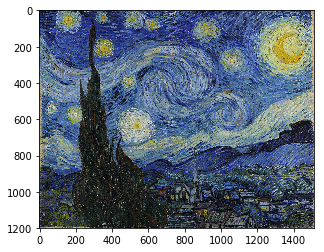

In [ ]:
plt.imshow(style_img);

In [ ]:
h,w,_ = style_img.shape
rat = max(sz/h,sz/h)
res = cv2.resize(style_img, (int(w*rat), int(h*rat)), interpolation=cv2.INTER_AREA)
resz_style = res[:sz,-sz:]

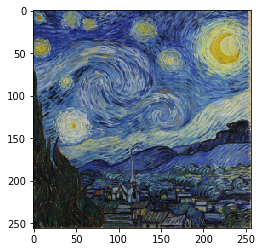

In [ ]:
plt.imshow(resz_style);

In [ ]:
style_tfm,_ = tfms[1](resz_style,resz_style)

In [ ]:
style_tfm = np.broadcast_to(style_tfm[None], (bs,)+style_tfm.shape)

In [ ]:
style_tfm.shape

(24, 3, 256, 256)

## Perceptual loss

In [ ]:
m_vgg = vgg16(True)

In [ ]:
blocks = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)]
blocks, [m_vgg[i] for i in blocks[1:]]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [ ]:
vgg_layers = children(m_vgg)[:43]
m_vgg = nn.Sequential(*vgg_layers).cuda().eval()
set_trainable(m_vgg, False)

In [ ]:
def flatten(x): return x.view(x.size(0), -1)

In [ ]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()        

In [ ]:
def ct_loss(input, target): return F.mse_loss(input,target)

def gram(input):
        b,c,h,w = input.size()
        x = input.view(b, c, -1)
        return torch.bmm(x, x.transpose(1,2))/(c*h*w)*1e6

def gram_loss(input, target):
    return F.mse_loss(gram(input), gram(target[:input.size(0)]))

In [ ]:
class CombinedLoss(nn.Module):
    def __init__(self, m, layer_ids, style_im, ct_wgt, style_wgts):
        super().__init__()
        self.m,self.ct_wgt,self.style_wgts = m,ct_wgt,style_wgts
        self.sfs = [SaveFeatures(m[i]) for i in layer_ids]
        m(VV(style_im))
        self.style_feat = [V(o.features.data.clone()) for o in self.sfs]

    def forward(self, input, target, sum_layers=True):
        self.m(VV(target.data))
        targ_feat = self.sfs[2].features.data.clone()
        self.m(input)
        inp_feat = [o.features for o in self.sfs]
        
        res = [ct_loss(inp_feat[2],V(targ_feat)) * self.ct_wgt]
        res += [gram_loss(inp,targ)*wgt for inp,targ,wgt
                in zip(inp_feat, self.style_feat, self.style_wgts)]
        
        if sum_layers: res = sum(res)
        return res
    
    def close(self):
        for o in self.sfs: o.remove()

In [ ]:
m = StyleResnet()
m = to_gpu(m)

In [ ]:
learn = Learner(md, SingleModel(m), opt_fn=optim.Adam)

In [ ]:
learn.crit = CombinedLoss(m_vgg, blocks[1:], style_tfm, 1e4, [0.025,0.275,5.,0.2])

In [ ]:
wd=1e-7

 53%|█████▎    | 254/482 [02:27<02:12,  1.73it/s, loss=1.13e+12]

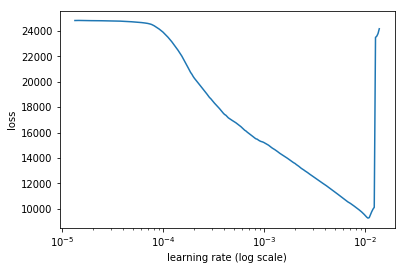

In [ ]:
learn.lr_find(wds=wd)
learn.sched.plot(n_skip_end=1)

In [ ]:
lr=5e-3

In [ ]:
learn.fit(lr, 1, cycle_len=1, wds=wd, use_clr=(20,10))

epoch      trn_loss   val_loss                               
    0      105.351372 105.833994



[array([105.83399])]

In [ ]:
learn.save('style-2')

In [ ]:
x,y=md.val_ds[len(val_x)-1]

In [ ]:
learn.model.eval()
preds = learn.model(VV(x[None]))
x.shape,y.shape,preds.shape

((3, 256, 256), (3, 256, 256), torch.Size([1, 3, 256, 256]))

In [ ]:
learn.crit(preds, VV(y[None]), sum_layers=False)

[Variable containing:
  53.2221
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  3.8336
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  4.0612
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  5.0639
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  53.0019
 [torch.cuda.FloatTensor of size 1 (GPU 0)]]

In [ ]:
learn.crit.close()

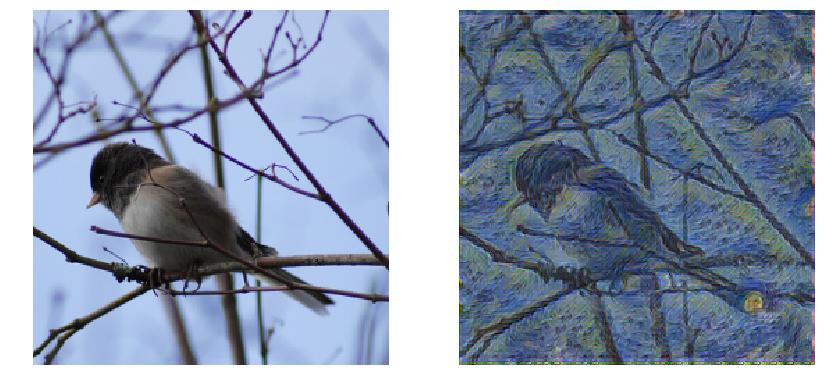

In [ ]:
_,axes=plt.subplots(1,2,figsize=(14,7))
show_img(x[None], 0, ax=axes[0])
show_img(preds, 0, ax=axes[1])

## Fin